# IMPORTS

In [5]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# DATASET

Dataset completo

In [6]:
dataset_dir = os.path.join(os.getcwd(), 'dataset')

Dataset treinamento

In [7]:
dataset_train = os.path.join(dataset_dir, 'training_set') # completo

# verificando a quantidade de dados por classe
dataset_train_verdes = len(os.listdir(os.path.join(dataset_train, 'verde'))) # dados de treinamento bananas verdes
dataset_train_maduras = len(os.listdir(os.path.join(dataset_train, 'madura'))) # dados de treinamento bananas maduras
print('Total de dados de treinamento: {}' .format(dataset_train_verdes + dataset_train_maduras))

Total de dados de treinamento: 945


In [8]:
dataset_test = os.path.join(dataset_dir, 'test_set') # completo

# verificando a quantidade de dados por classe
dataset_test_verdes = len(os.listdir(os.path.join(dataset_test, 'verde'))) # dados de treinamento bananas verdes
dataset_test_maduras = len(os.listdir(os.path.join(dataset_test, 'madura'))) # dados de treinamento bananas maduras
print('Total de dados de teste: {}' .format(dataset_test_verdes + dataset_test_maduras))

Total de dados de teste: 407


# Pré Processamento de Imagens

Definindo tamanho das imagens e características dos canais de cores (RGB)

In [18]:
image_width = 160
image_height = 160
image_color_channel = 3 # RGB
image_color_channel_size = 255 # valores para cada canal RGB vai de 0 a 255
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel,)

class_names = ['Madura', 'Verde']

Batch Size, Epochs, Learning Rate

In [11]:
batch_size = 32 # quantidade de features que irá trazer por vez do dataset (32 é default)
epochs = 20 # número de vezes que irá passar pelo dataset inteiro
learning_rate = 0.0001 # taxa de aprendizagem

In [12]:
db_treinamento = tf.keras.preprocessing.image_dataset_from_directory(
                                                        'dataset/training_set',
                                                        image_size = image_size,
                                                        batch_size = batch_size,
                                                        shuffle = True
                                                        )

db_test = tf.keras.preprocessing.image_dataset_from_directory(
                                                        'dataset/test_set',
                                                        image_size = image_size,
                                                        batch_size = batch_size,
                                                        shuffle = True
                                                        )                                                      

Found 945 files belonging to 2 classes.
Found 407 files belonging to 2 classes.


Dataset validação - uma parte do dataset de teste para testar realmente o modelo

In [13]:
dataset_test_cardinality = tf.data.experimental.cardinality(db_test)
dataset_test_batches = dataset_test_cardinality // 5

db_validation = db_test.take(dataset_test_batches)
db_test = db_test.skip(dataset_test_batches)

print('Validation Dataset Cardinality: %d' % tf.data.experimental.cardinality(db_validation))
print('Test Dataset Cardinality: %d' % tf.data.experimental.cardinality(db_test))

Validation Dataset Cardinality: 2
Test Dataset Cardinality: 11


# Modelo RNA Convolucional

In [14]:
model = tf.keras.models.Sequential([

    tf.keras.layers.experimental.preprocessing.Rescaling(
        1. / image_color_channel_size,
        input_shape = image_shape
    ),
    tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        3

In [15]:
history = model.fit(
    db_treinamento,
    validation_data = db_test,
    epochs = epochs
)

Epoch 1/20
30/30 [==============================] - 20s 588ms/step - loss: 0.3234 - accuracy: 0.8751 - val_loss: 0.2229 - val_accuracy: 0.8980
Epoch 2/20
30/30 [==============================] - 17s 558ms/step - loss: 0.2003 - accuracy: 0.9122 - val_loss: 0.1512 - val_accuracy: 0.9621
Epoch 3/20
30/30 [==============================] - 17s 556ms/step - loss: 0.1022 - accuracy: 0.9566 - val_loss: 0.0800 - val_accuracy: 0.9767
Epoch 4/20
30/30 [==============================] - 17s 563ms/step - loss: 0.0521 - accuracy: 0.9778 - val_loss: 0.0487 - val_accuracy: 0.9825
Epoch 5/20
30/30 [==============================] - 17s 553ms/step - loss: 0.0250 - accuracy: 0.9926 - val_loss: 0.0707 - val_accuracy: 0.9767
Epoch 6/20
30/30 [==============================] - 17s 553ms/step - loss: 0.0212 - accuracy: 0.9937 - val_loss: 0.0151 - val_accuracy: 0.9971
Epoch 7/20
30/30 [==============================] - 17s 561ms/step - loss: 0.0095 - accuracy: 0.9979 - val_loss: 0.0232 - val_accuracy: 0.9942

In [19]:
def plot_dataset_predictions(dataset):
    features, labels = dataset.as_numpy_iterator().next()

    predictions = model.predict_on_batch(features).flatten()
    predictions = tf.where(predictions < 0.5, 0, 1)

    print('Labels: {}' .format(labels))
    print('Predictions: {}' .format(predictions.numpy()))

    plt.gcf().clear()
    plt.figure(figsize = (15,15))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.axis('off')

        plt.imshow(features[i].astype('uint8'))
        plt.title(class_names[predictions[i]])

Labels: [1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0]
Predictions: [1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0]


<Figure size 640x480 with 0 Axes>

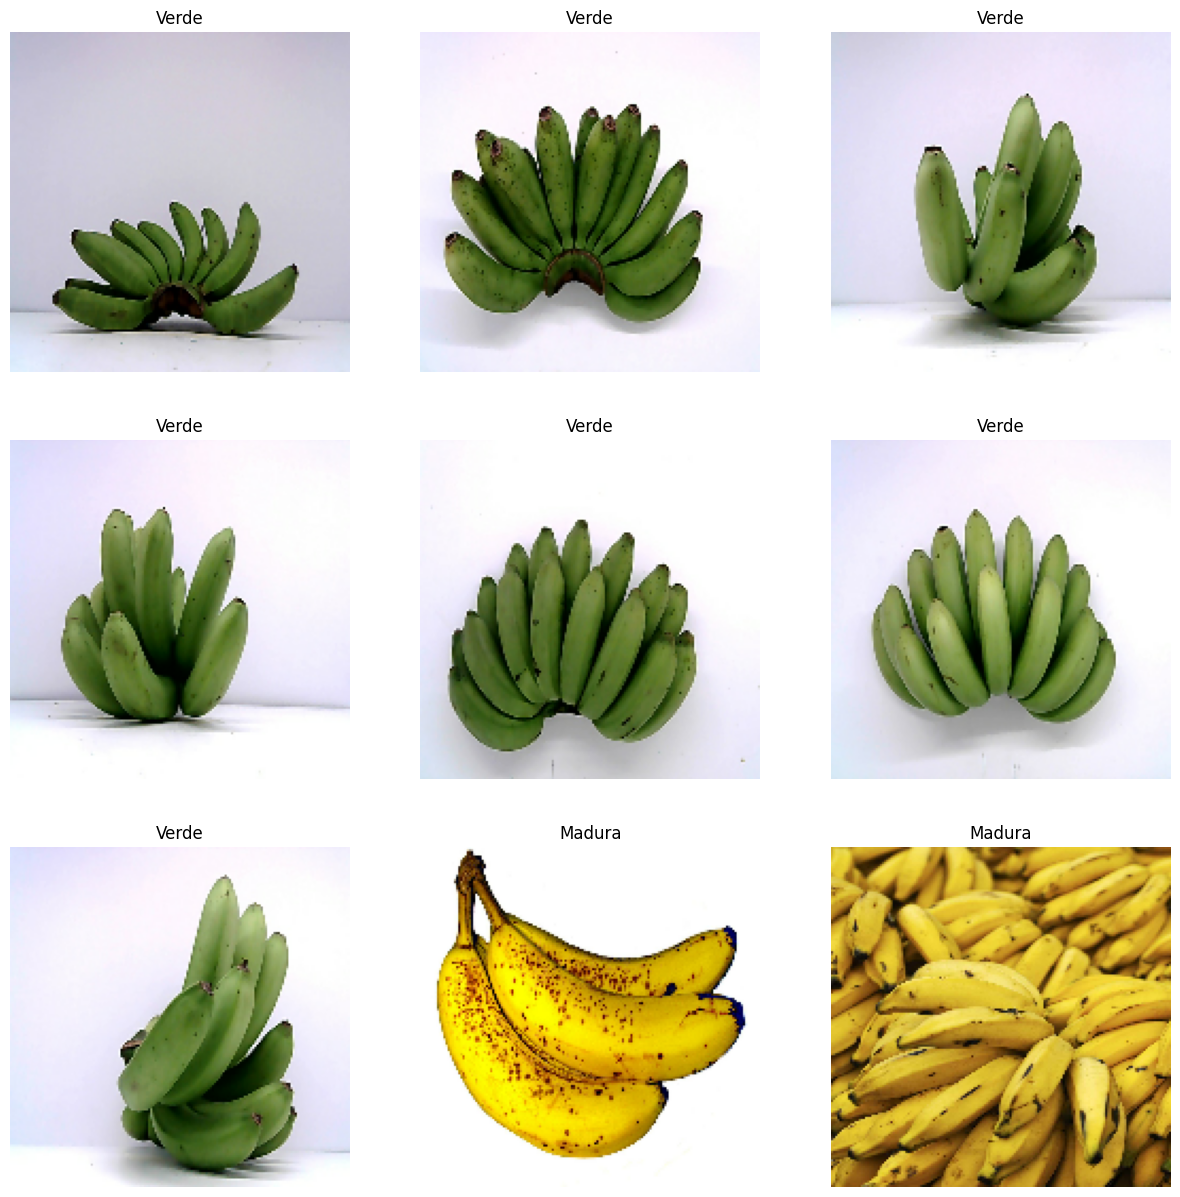

In [20]:
plot_dataset_predictions(db_test)

# Validação

In [63]:
def plot_model():
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.gcf().clear()
    plt.figure(figsize=(16,8))

    plt.subplot(1,2,1)
    plt.title('ACURÁCIA DE TREINAMENTO E TESTE')
    plt.plot(epochs_range, accuracy)
    plt.plot(epochs_range, val_accuracy)
    plt.legend(('Treinamento','Teste'))

    plt.subplot(1,2,2)
    plt.title('FUNÇÃO DE PERDA DO TREINAMENTO E TESTE')
    plt.plot(epochs_range, loss, label = 'Perda no Treinamento')
    plt.plot(epochs_range, val_loss, label = 'Perda no Teste')
    plt.legend(('Treinamento','Teste'))

    plt.show()

<Figure size 640x480 with 0 Axes>

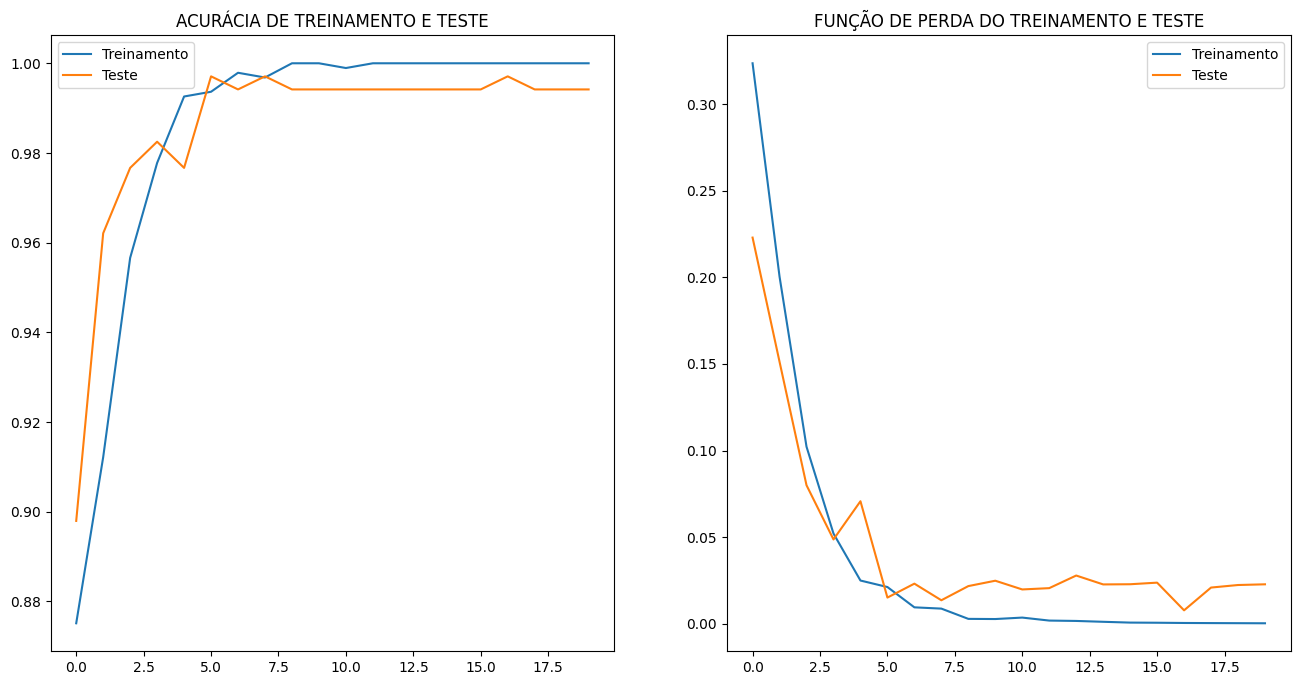

In [64]:
plot_model()

# Salvando Modelo

In [25]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [26]:
model = tf.keras.models.load_model('model')

# Classificando uma imagem fora do dataset

1/1 [==============================] - 0s 25ms/step
Madura [[0.9999712]]


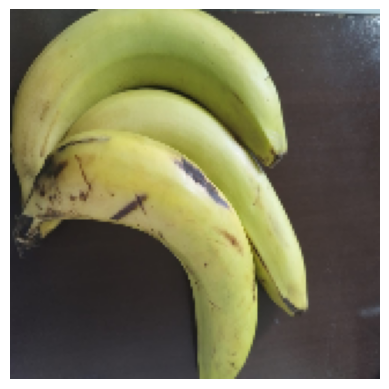

In [69]:
imagem_valida = image.load_img('dataset/valida2.jpg',
                                target_size = (160,160)
                                )
imagem = image.img_to_array(imagem_valida)
imagem /= 255 #normalização
imagem = np.expand_dims(imagem, axis = 0) #expandir dimensões // formato para o tensor flow
valida = model.predict(imagem)

if (valida > 0.5):
    print('Madura', valida)
else:
    print('Verde')

plt.imshow(imagem_valida)
plt.axis('off')
plt.show()
